# **Pneumonia Detection**
**A machine learning project for detecting pneumonia from chest X-ray images. It includes data preprocessing, feature extraction, and performance evaluation to aid early diagnosis.**

## **Traditional Model Tuning**

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import ClassifierMixin
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

KFOLD = 5

### **③ Learning Curve**
Illustrates how the classifier's performance evolves as the volume of training data increases. The red line tracks the training score, whereas the green line represents the cross-validation (test) score. Shaded regions surrounding each line highlight the variability in these scores. A high training score paired with a low validation score may suggest overfitting, while low scores on both curves can indicate underfitting.

In [2]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(
  estimator: ClassifierMixin, X_train: np.ndarray, y_train: np.ndarray, ax: Axes
):
  _, train_scores, test_scores, _, _ = learning_curve(
    estimator, X_train, y_train, cv=KFOLD, n_jobs=-1, return_times=True
  )

  train_sizes = np.linspace(0.1, 1.0, 5)

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  ax.grid()
  ax.set_xlim(0.0, 1.05)
  ax.set_ylim(0.0, 1.05)
  ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
  )
  ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
  )
  ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
  ax.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
  )
  ax.legend(loc="best")
  plot_title = f"{type(estimator).__name__} Learning Curve"
  ax.set_title(plot_title)


### **③ GridSearch Results**
Visualizes the performance of various hyperparameter combinations evaluated during the grid search process. Each bar represents the mean test score for a particular parameter configuration, arranged in descending order. The x-axis label highlights the best-performing configuration identified by the grid search.

In [3]:
from sklearn.model_selection import GridSearchCV


def plot_gridsearch_results(grid: GridSearchCV, estimator: ClassifierMixin, ax: Axes):
  results = pd.DataFrame(grid.cv_results_)
  plot_cols = [col for col in results.columns if "split" in col and "test" in col]
  results = results[plot_cols].mean(axis=1).sort_values(ascending=False)
  plot_title = f"{type(estimator).__name__} GridSearch Result"

  ax.bar(
    range(len(results)),
    results,
    align="center",
    alpha=0.8,
    color="skyblue",
  )
  ax.set_ylabel("Mean Test Score")
  ax.set_xlabel(f"Best = {grid.best_params_}", fontsize=8)
  ax.set_title(plot_title)

### **③ Confusion Matrix**
Presents the confusion matrix for the classifier, comparing the actual test labels with the predicted results. The varying shades of blue indicate the frequency of predictions, making it easy to identify areas where the model excels or needs improvement.

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(
  estimator: ClassifierMixin, y_test: np.ndarray, y_guess: np.ndarray, ax: Axes
):
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_guess))
  disp.plot(ax=ax, cmap=plt.cm.Blues)
  plot_title = f"{type(estimator).__name__} Confusion Matrix"
  disp.ax_.set_title(plot_title)

### **③ AUC-ROC Curve**
Displays the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) across different classification thresholds. The area under the ROC curve (AUC) quantifies the model's ability to distinguish between the classes (the closer the AUC is to 1, the better the performance). The gray dashed line represents a baseline where predictions are equivalent to random guessing.

In [5]:
from sklearn.metrics import roc_curve, auc


def plot_aucroc_curve(
  estimator: ClassifierMixin, X_test: np.ndarray, y_test: np.ndarray, ax: Axes
):
  y_pred_proba = estimator.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
  roc_auc = auc(fpr, tpr)
  pd.DataFrame({"fpr": fpr, "tpr": tpr}).plot(
    "fpr",
    "tpr",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    label=f"AUC = {roc_auc:.3f}",
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    grid=True,
    title=f"{type(estimator).__name__} AUC-ROC Curve",
    ax=ax,
  )
  ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
  ax.legend(loc="lower right")

### **③ Precision-Recall Curve**
Shows the trade-off between precision and recall as the decision threshold shifts. The curve's area, expressed as the Average Precision (AP) score, encapsulates the model's overall performance. A higher AP score suggests an excellent balance between precision and recall, a critical measure when dealing with imbalanced datasets. The gray dashed line serves as a baseline for comparison.

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_prcrcl_curve(
  estimator: ClassifierMixin, X_test: np.ndarray, y_test: np.ndarray, ax: Axes
):
  y_pred_proba = estimator.predict_proba(X_test)[:, 1]
  precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
  avg_precision = average_precision_score(y_test, y_pred_proba)
  pd.DataFrame({"recall": recall, "precision": precision}).plot(
    "recall",
    "precision",
    xlabel="Recall",
    ylabel="Precision",
    label=f"AP = {avg_precision:.3f}",
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    grid=True,
    title=f"{type(estimator).__name__} Precision-Recall Curve",
    ax=ax,
  )
  ax.plot([0, 1], [1, 0], color="gray", linestyle="--")
  ax.legend(loc="lower left")


### **② Hyperparameter Tuning**
Utilizes GridSearchCV with stratified k-fold cross-validation to optimize hyperparameters based on the F1 score. Once the best estimator is selected, multiple plots are generated to diagnose model performance, including the learning curve, confusion matrix, AUC-ROC curve, and precision-recall curve. Finally, the performance metrics (F1, precision, and recall) on the test set is returned.

In [7]:
from contextlib import contextmanager
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold


@contextmanager
def suppress_gridsearch_warnings():
  import os
  import warnings
  from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

  original = os.environ.get("PYTHONWARNINGS", "")
  os.environ["PYTHONWARNINGS"] = "ignore"
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FitFailedWarning)
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    try:
      yield
    finally:
      os.environ["PYTHONWARNINGS"] = original


def tune_hyperparameter(
  clf: ClassifierMixin,
  grid: dict,
  X_train: np.ndarray,
  y_train: np.ndarray,
  X_test: np.ndarray,
  y_test: np.ndarray,
  axes: np.ndarray,
) -> list:
  cv = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=42)
  grid_search = GridSearchCV(
    clf,
    grid,
    scoring=make_scorer(f1_score),
    cv=cv,
    # verbose=10  # Uncomment this line to log the triaining process.
    n_jobs=-1,
    return_train_score=True,
  )
  with suppress_gridsearch_warnings():
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    plot_learning_curve(best_clf, X_train, y_train, axes[0])
    # plot_gridsearch_results(grid_search, best_clf, axes[1])
    y_guess = best_clf.predict(X_test)
    plot_confusion_matrix(best_clf, y_test, y_guess, axes[1])
    plot_aucroc_curve(best_clf, X_test, y_test, ax=axes[2])
    plot_prcrcl_curve(best_clf, X_test, y_test, ax=axes[3])

  return [
    f1_score(y_test, y_guess),
    precision_score(y_test, y_guess),
    recall_score(y_test, y_guess),
  ]

### **① Model Recipes for Hyperparameter Tuning**
Defines a collection of model recipes by pairing several classifiers with detailed hyperparameter grids for each.

In [8]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

recipes = [
  (
    SVC(probability=True, random_state=42),
    {
      "C": [0.1, 1, 10, 100],
      "kernel": ["linear", "rbf", "poly", "sigmoid"],
      "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
      "degree": [2, 3, 4],  # Only used with the 'poly' kernel
      "coef0": [0.0, 0.1, 0.5, 1],  # Only used with 'poly' or 'sigmoid' kernels
    },
  ),
  (
    DecisionTreeClassifier(random_state=42),
    {
      "criterion": ["gini", "entropy"],  # Options for impurity measure
      "max_depth": [None, 5, 10, 20, 30],  # Maximum depth of the tree
      # Minimum number of samples required to split an internal node
      "min_samples_split": [2, 5, 10, 20],
      # Minimum number of samples required to be at a leaf node
      "min_samples_leaf": [1, 2, 4, 6],
      # Number of features to consider when looking for the best split
      "max_features": [None, "sqrt", "log2"],
    },
  ),
  (
    KNeighborsClassifier(),
    {
      "n_neighbors": list(range(1, 31)),  # Try neighbors from 1 to 30
      "weights": ["uniform", "distance"],  # Uniform weights or distance-based weighting
      # Algorithm to compute nearest neighbors
      "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
      "leaf_size": [10, 20, 30, 40, 50],  # Leaf size for tree-based algorithms
      "p": [1, 2],  # p=1 for Manhattan distance, p=2 for Euclidean distance
    },
  ),
  (
    GaussianNB(),
    {
      "var_smoothing": np.logspace(-9, -1, num=9)  # Explore values from 1e-9 to 1e-1
    },
  ),
  (
    LogisticRegression(random_state=42),
    {
      "penalty": ["l1", "l2"],  # Regularization type
      # Inverse of regularization strength; smaller values specify stronger regularization
      "C": [0.1, 1, 10, 100],
      "solver": ["liblinear", "saga"],  # Solvers that support both l1 and l2 penalties
      "max_iter": [100, 200, 300],  # Maximum number of iterations for convergence
    },
  ),
  (
    RandomForestClassifier(random_state=42),
    {
      "n_estimators": [100, 200, 300],  # Number of trees in the forest.
      "max_depth": [None, 10, 20, 30],  # Maximum depth of each tree.
      # Minimum number of samples required to split an internal node.
      "min_samples_split": [2, 5, 10],
      # Minimum number of samples required to be at a leaf node.
      "min_samples_leaf": [1, 2, 4],
      # Number of features to consider when looking for the best split.
      "max_features": ["sqrt", "log2", None],
      # Whether bootstrap samples are used when building trees.
      "bootstrap": [True, False],
    },
  ),
  (
    AdaBoostClassifier(random_state=42),
    {
      "n_estimators": [50, 100, 200],  # Number of weak learners (estimators)
      # Weight applied to each classifier at each boosting iteration
      "learning_rate": [0.01, 0.1, 1, 10],
    },
  ),
  (
    XGBClassifier(eval_metric="logloss", random_state=42),
    {
      "n_estimators": [50, 100, 200],  # Number of boosting rounds
      "max_depth": [3, 5, 7],  # Maximum depth of a tree
      # Step size shrinkage used in update to prevent overfitting
      "learning_rate": [0.01, 0.1, 0.2],
      "subsample": [0.8, 1.0],  # Subsample ratio of the training instances
      # Subsample ratio of columns when constructing each tree
      "colsample_bytree": [0.8, 1.0],
      "reg_alpha": [0, 0.1, 1],  # L1 regularization term on weights
      "reg_lambda": [1, 1.5, 2],  # L2 regularization term on weights
    },
  ),
]

### **① Pneumonia Classification Pipeline**
Loads a pneumonia dataset and splits the data into training and testing sets. Then, create a multi-panel figure to display several diagnostic plots for each classifier in the recipes.

SVC
DecisionTreeClassifier
KNeighborsClassifier
GaussianNB
LogisticRegression
RandomForestClassifier
AdaBoostClassifier
XGBClassifier


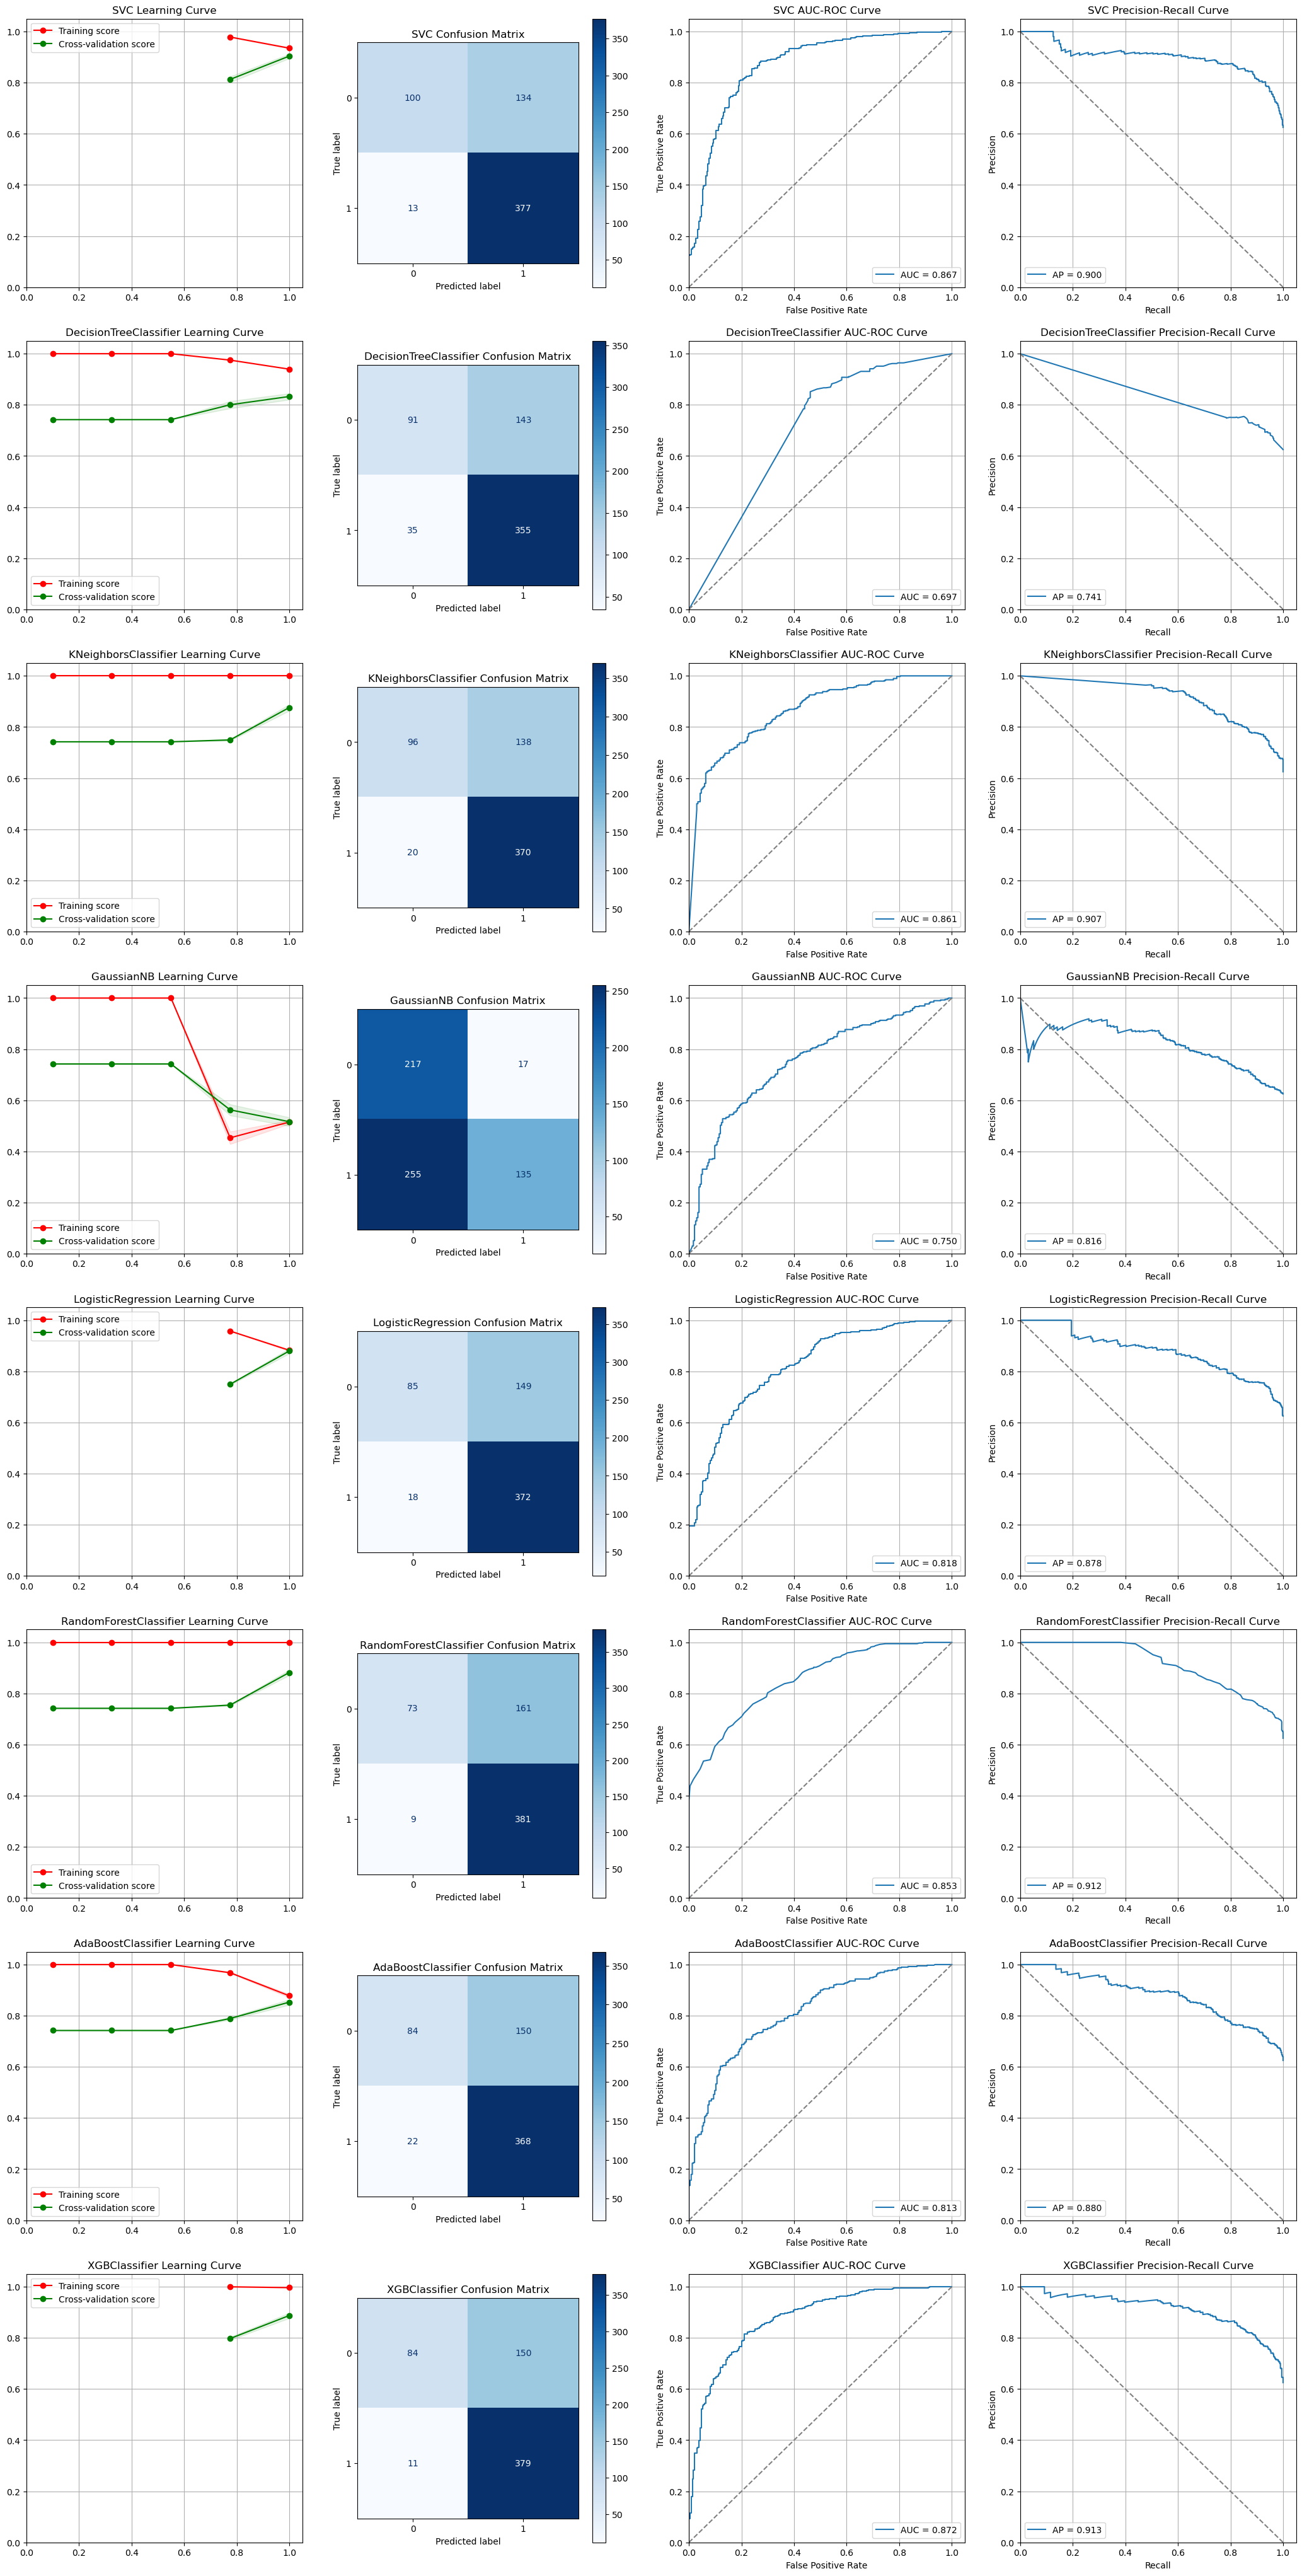

In [9]:
from _data import load_pneumonia

fig, axs = plt.subplots(len(recipes), 4, figsize=(26, 6.5 * len(recipes)))
train, test = load_pneumonia(
  include_raw=False, include_hog=False, include_lbp=True, pca_mode="none"
)
X_train, y_train = np.split(train, [-1], axis=1)
X_test, y_test = np.split(test, [-1], axis=1)
test_score = pd.DataFrame(columns=["F1", "Precision", "Recall"])
for index, (clf, grid) in enumerate(recipes):
  print(type(clf).__name__)
  test_score.loc[type(clf).__name__] = tune_hyperparameter(
    clf, grid, X_train, y_train.flatten(), X_test, y_test.flatten(), axs[index, :]
  )
plt.show()

### **④ Model Performance Comparison**
Compares the performance of various classifier on the testing set with bar chart. Model names are displayed along the x-axis, while their corresponding scores appear on the y-axis.

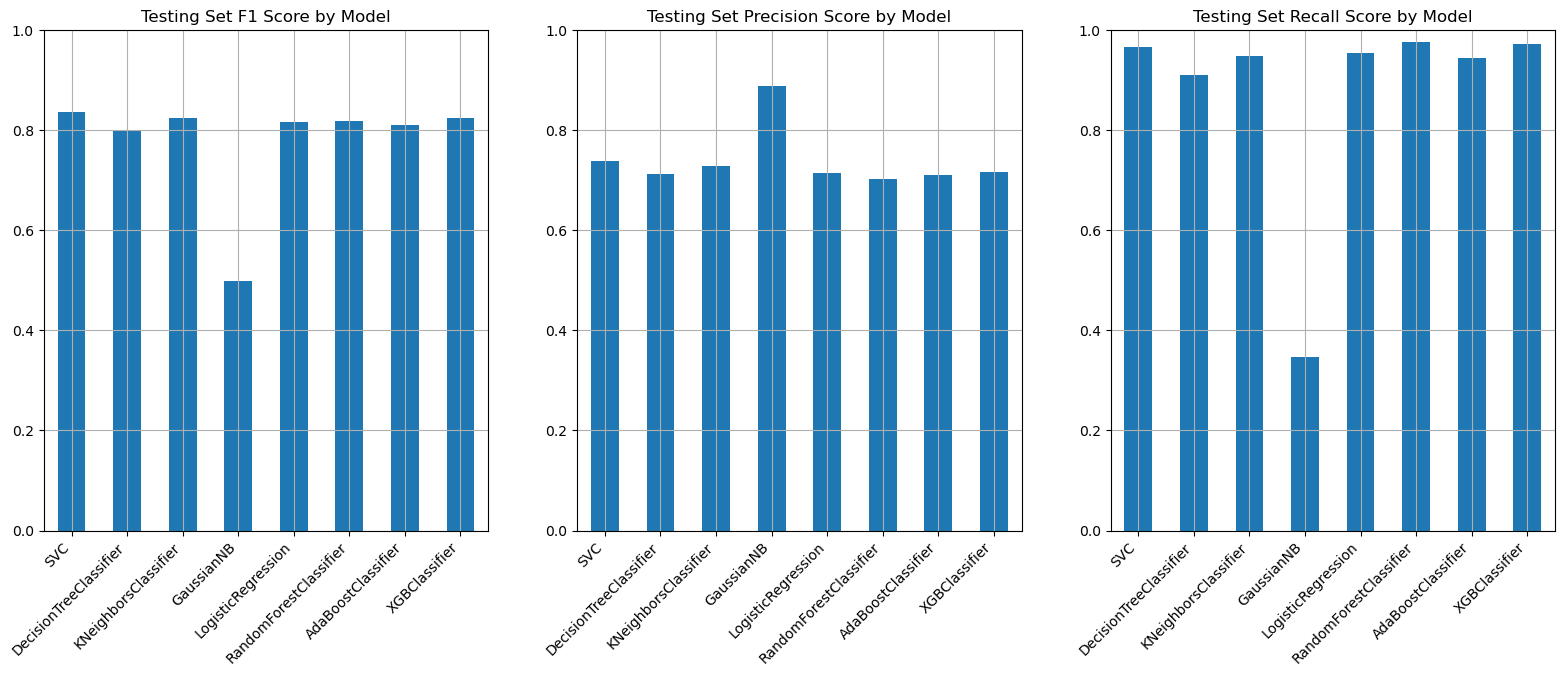

In [10]:
_, axs = plt.subplots(1, 3, figsize=(19.5, 6.5))
for index, col in enumerate(test_score.columns):
  ax = axs[index]
  test_score.plot.bar(
    y=col,
    use_index=True,
    ylim=[0.0, 1.0],
    legend=False,
    grid=True,
    title=f"Testing Set {col} Score by Model",
    ax=ax,
  )
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")